## Initialization

In [179]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from collections import namedtuple, deque
from tic_env import TictactoeEnv, OptimalPlayer

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

# Set seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
import random
random.seed(SEED)

# Constants
ALPHA = 0.05
GAMMA = 0.99
EPSILON = 0.3 # Arbitrary
DELTA = 1 # For Huber loss
E_MIN = 0.1
E_MAX = 0.8

## *Q*-Learning

#### Helpers

In [180]:
# Q-learning helpers


# Thanks to Jeremy Zhang for the idea of how to encode the state
# https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542
def encode(S, A):
    ''' Unique encoder for a given state-action pair \n
        Args: 
            S: TictactoeEnv. Represents the current state.
            A: Tuple[Int] or Int. Represents the action to be taken.
        Returns:
            String. Unique representation of (S, A)
    '''
    if isinstance(A, tuple):
        A = A[0] * 3 + A[1]
    return f'{S.grid.reshape(9)}:{A}'

def get_legal_moves(S):
    ''' Helper for getting legal moves given state S \n
        Args:
            S: TictactoeEnv. Current state.
        Returns: 
            List[Int]. Legal moves.
    '''
    legal_moves = []
    for i in range(9):
        if S.check_valid(i):
            legal_moves.append(i)
    return legal_moves


def choose_action(S, e, Q, player='X'):
    """ Choose next action given current state, epsilon and saved states \n
        Args: 
            S: TictactoeEnv. Current state.
            e: Float. Epsilon value in range [0, 1].
            Q: Dict[String, Float]. Learned Q function.
        Returns: 
            Int. A legal action.

    """
    actions = get_legal_moves(S)
    if np.random.uniform(0, 1) <= e:
        i = np.random.choice(len(actions))
        return actions[i]
    else:
        value_max = -9999
        for a in actions:
            # Get Q(S, a) from saved, or 0 if not encountered
            value = Q.get(encode(S, a), 0)
            if value > value_max:
                value_max = value
                A = a
        return A


def test(Q, rand, e=0):
    ''' Function for computing M_opt and M_rand \n
        Args:
            Q: Dict[String, Float]. Learned Q function.
            rand: Boolean. True if calculating M_rand and False if calculating M_opt.
            e: Float. Exploration level, should be zero for testing. 
        Returns: 
            Float. (num_wins - num_losses) / num_games.
    '''
    rewards = []
    S = TictactoeEnv()
    for i in range(500): # Fixed number of test games
        np.random.seed(i) # Different seed for each iteration
        p = OptimalPlayer(int(rand), 'O') if i % 2 == 0 else OptimalPlayer(int(rand), 'X')
        while not S.end:
            if S.current_player != p.player:
                A = choose_action(S, e, Q)
            else:
                A = p.act(S.grid)

            grid, end, winner = S.step(A)
            if end:
                # 1 if policy wins, -1 if policy loses, else 0
                R = - S.reward(player=p.player)
                rewards.append(R)
                S.reset()
                break
    np.random.seed(42)
    return sum(rewards)  / len(rewards)


def plot_subplots(rows, cols, x, ys, hyperparam, suptitle, 
                  xlabel, ylabel, labels=[], legend_title='', subtitle=''):
    """ Function for plotting subplots
        Args: 
            (rows, cols): (Int, Int). Subplot format.
            x: Iterable[Int]. Values of x-axis.
            ys: ndarray[Int] of shape (num_subplots, num_labels, len(x)). Values to be plotted.
                Example: If plotting both M_opt and M_rand in each subplot, num_labels=2
            hyperparam: Iterable[Float]. Hyperparameter that differs over subplots.
            suptitle: String. Super title.
            xlabel: String. Label of x-axis.
            ylabel: String. Label of y-axis.
            labels: Iterable[String] of length ys.shape[1]. Optional labels.
            legend_title: String. Optional legend title.
            subtitle: String. Optional (generic) subtitle of each subplot, is combined with hyperparam. 
    """

    fig, axs = plt.subplots(rows, cols, figsize=(18, 14), sharex=True, sharey=True)
    axs = axs.flatten()

    # Reveal x-ticks and y-ticks on all subplots -> Doesnt work
    for ax in axs:
        for (x_tick, y_tick) in zip(ax.get_xticklabels(), ax.get_yticklabels()):
            x_tick.set_visible(True)
            y_tick.set_visible(True)

    # Plot
    plt.suptitle(suptitle, fontsize=30)
    for i, (hp, y) in enumerate(zip(hyperparam, ys)):
        for reward in y:   
            sns.lineplot(x=x, y=reward, ax=axs[i])
        axs[i].set_title(f'{subtitle} = {hp}', fontsize=24)
        if labels != []:
            axs[i].legend(title=legend_title, labels=labels, loc='lower right')

    fig.text(0.5, 0.04, xlabel, ha='center', fontsize=26)
    fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical', fontsize=26)



In [ ]:
# Function for training
# Could change the representation to take the 'afterstate' instead of state-action pairs. 
# This is more efficient, as several state-action pairs can lead to the same afterstate (Sutton & Barto, 2018)
def train(N, e=0.1, e_opt=0.5, compute_every=250, decrease_epsilon=False, dec_factor=1, 
          compute_tests=False, itself=False):
    """ Function for training a policy Sarsa \n
        Args:
            N: Int. Number of games.
            e: Float. Epsilon value in [0, 1].
            e_opt: Float. Epsilon value for OptimalPlayer in [0, 1]
            compute_every: Int. Number of games before compute training and test average.
            decrease_epsilon: Boolean. True if epsilon should be decreased each game.
            dec_factor: Int. Decreasing factor for epsilon.
            compute_tests: Boolean. True if M_opt and M_rand should be computed.
            itself: Boolean. True if the algorithm should learn by playing itself.
        Returns: 
            Tuple. Training rewards, M_opt and M_rand, losses averaged over buckets of size compute_every, Q function
    """
    Q = {}
    S = TictactoeEnv() # Init env
    avg_rewards = [0]
    curr_rewards = []
    m_opt, m_rand = [0], [0]
    avg_losses = [0]
    for i in range(N): 
        if i % 5000 == 0:
            print(f'Starting game {i}')
        # Compute reward (and test)
        if i % compute_every == 0 and i > 0:
            avg_rewards.append(np.mean(curr_rewards))
            curr_rewards = []
            if compute_tests:
                m_opt.append(test(Q, False))
                m_rand.append(test(Q, True))
        # Decrease epsilon
        if decrease_epsilon:
            e = max(E_MIN, E_MAX*(1 - i / dec_factor))

        # Switch starting player
        opt = OptimalPlayer(e_opt, 'O') if i % 2 == 0 else OptimalPlayer(e_opt, 'X')

        # Keep track of explored states, 
        # along with the action and the following next state (for Deep Q-learning)
        states = []

        # Play game
        while not S.end:
            
            # Our turn
            if S.current_player != opt.player:
                A = choose_action(S, e, Q)
                state_action = encode(S, A)
                states.append(state_action)

            # Optimal algorithm's turn
            else:
                # if we play against ourselves, we choose the action in the moral sense
                if itself:
                    A = choose_action(S, e, Q)
                    state_action = encode(S, A)
                    states.append(state_action)
                else: 
                    A = opt.act(S.grid)
            # Store whether the action is valid 
            valid_action = S.check_valid(A)

            # Perform action if valid 
            if valid_action:
                grid, end, winner = S.step(A)
            if end:
                # Calculate and store our reward
                if valid_action:
                    # calculating the correct sign of reward when we play against ourselves
                    if itself and S.current_player != opt.player:
                        R = S.reward(player=opt.player)
                    else:
                        R = - S.reward(player=opt.player) 
                # if the move is illegal; reward is -1
                else:
                    R = -1
                curr_rewards.append(R) 

                #Storing the next state for use in playing against expert
                next_Q = None 
                # storing the second next state for playing against itself
                # this is due to us saving states from "both sides of the table"
                next2_Q = None

                # iterating over the states LIFO
                for S_A in reversed(states):
                    value = Q.get(S_A, 0)

                    # logic to use correct next Q vlaue when playing against itself
                    if itself:
                        next = next2_Q
                    else:
                        next = next_Q
                    
                    # updating Q values
                    if next is None:
                        Q[S_A] = value + ALPHA * (R - value)
                    else:
                        Q[S_A] = value + ALPHA * (R + GAMMA * next - value)
                    
                    # making ready for next step of the iteration
                    next2_Q = next_Q
                    next_Q = Q[S_A]
                    
                    # if itself, reward must change sign between each iteration
                    if itself:
                        R = R*(-1)
                        

                # Reset and start new game
                S.reset()
                break
    
    # Quick fix
    np.random.seed(SEED)
    random.seed(SEED)
    return avg_rewards, m_opt, m_rand, avg_losses, Q

### 2.1 Learning from experts

#### Question 1

In [ ]:
rewards, _, _, _, _ = train(20000, e=0.1)

sns.set_theme(style='whitegrid')
fig = plt.figure(figsize=(18, 10))
X = np.linspace(0, 19750, 20000 // 250)
sns.lineplot(x=X, y=rewards)
plt.title('Average reward during training for every 250th game', fontsize=24)
plt.xlabel('Game number', fontsize=18)
plt.ylabel('Avg. reward for past 250 games', fontsize=18)

### 2.1.1 Decreasing exploration

#### Question 2

In [ ]:
dec_factors = [1, 5000, 10000, 20000, 30000, 40000]
rewards = []

for dec_factor in dec_factors:
    dec_rewards, _, _, _, hist = train(20000, dec_factor=dec_factor, decrease_epsilon=True)
    rewards.append(dec_rewards)

# Expand dims for plotting function
rewards = np.expand_dims(rewards, 1)

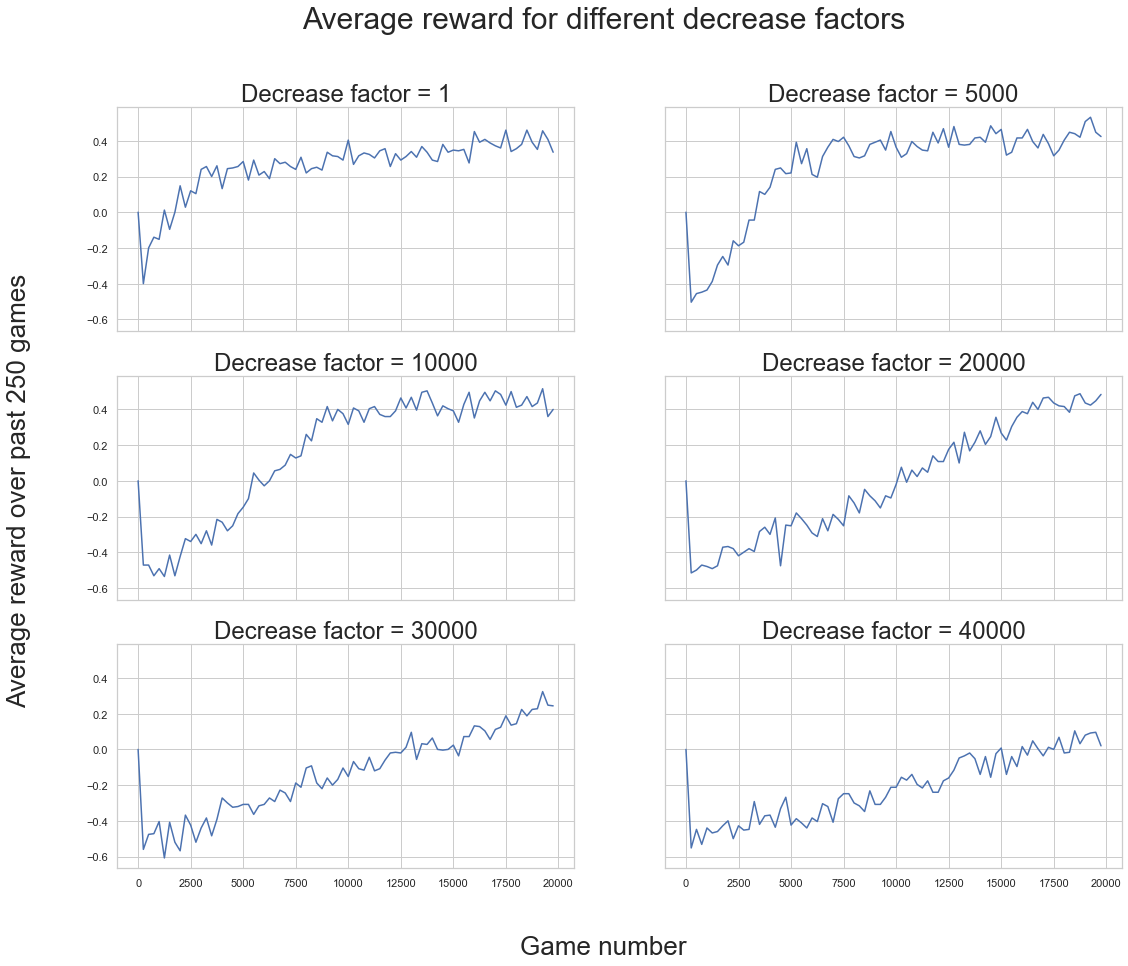

In [183]:
suptitle = 'Average reward for different decrease factors'
subtitle = 'Decrease factor'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
#rewards = np.expand_dims(rewards, 1)
plot_subplots(3, 2, X, rewards, dec_factors, suptitle, 
              xlabel, ylabel, subtitle=subtitle)

#### Question 3

In [ ]:
dec_factors = [1, 5000, 10000, 20000, 30000, 40000]
m_opts, m_rands = [], []

for dec_factor in dec_factors:
    _, m_opt, m_rand, _, _ = train(20000, dec_factor=dec_factor, decrease_epsilon=True, compute_tests=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Format and stack along axis=1
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)
m = np.hstack([m_opts, m_rands])

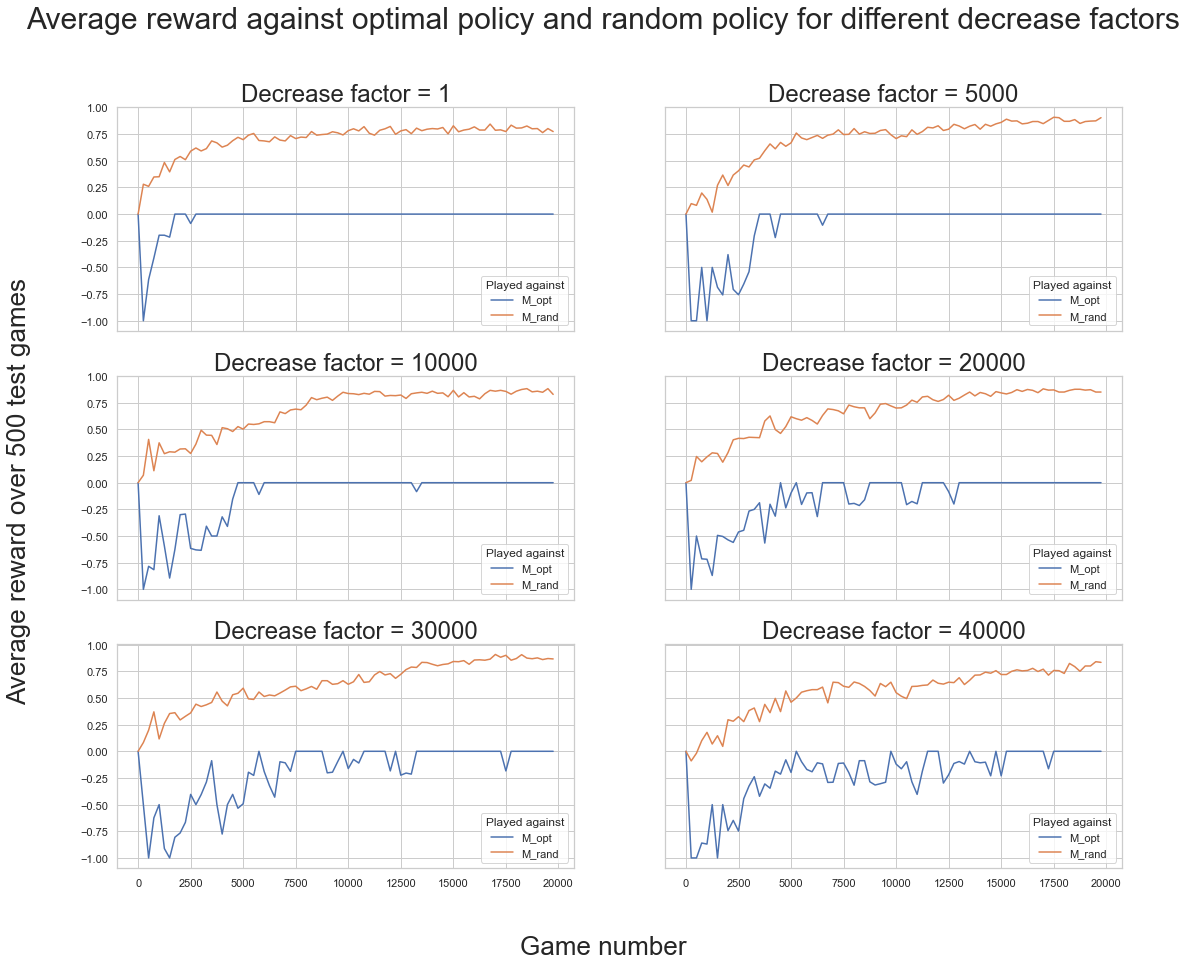

In [ ]:
suptitle = 'Average reward against optimal policy and random policy for different decrease factors'
subtitle = 'Decrease factor'
xlabel = 'Game number'
ylabel = 'Average reward over 500 test games'
plot_subplots(3, 2, X, m, dec_factors, suptitle, xlabel, ylabel, labels=['M_opt', 'M_rand'], 
              legend_title='Played against', subtitle=subtitle)


### 2.1.2 Good experts and bad experts

Choosing $n^*$ = 20000 as this value yields the highest average reward after 20000 games.

We further pick ${\epsilon}_{opt}$ from $[0, 0.1, 0.25, 0.5, 0.75, 0.9]$. 

#### Question 4

In [ ]:
e_opts = [0, 0.1, 0.25, 0.5, 0.75, 0.9]
m_opts, m_rands = [], []

for e_opt in e_opts:
    _, m_opt, m_rand, _, _ = train(20000, e_opt=e_opt, dec_factor=5000, decrease_epsilon=True, compute_tests=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])


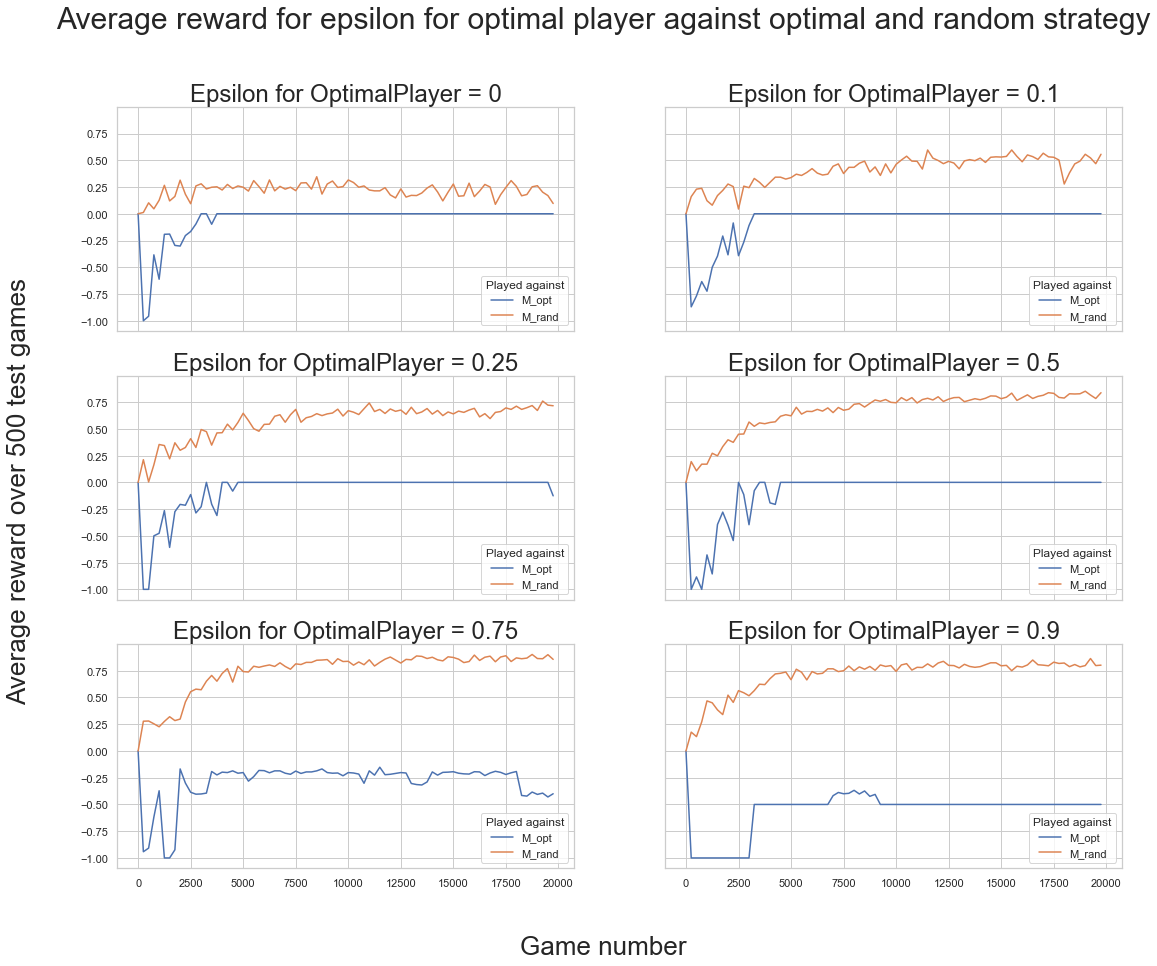

In [269]:
suptitle = 'Average reward for epsilon for optimal player against optimal and random strategy'
subtitle = 'Epsilon for OptimalPlayer'
xlabel = 'Game number'
ylabel = 'Average reward over 500 test games'
plot_subplots(3, 2, X, m, e_opts, suptitle, xlabel, ylabel,
              labels=['M_opt', 'M_rand'], legend_title='Played against',
              subtitle=subtitle)

#### Question 5

In [199]:
# Training the model that achieved best scores for the training against experts
_, m_opt, m_rand, _, _ = train(20000, e_opt=0.5, dec_factor=5000, decrease_epsilon=True, compute_tests=True)

max_m_opts = np.max(np.asarray(m_opt[1:]))
max_m_rands = np.max(np.asarray(m_rand[1:]))

print('The largest values of M_opt and M_rand are:')
print(f'M_opt: {max_m_opts}')
print(f'M_rand: {max_m_rands}')

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
The largest values of M_opt and M_rand are:
M_opt: 0.0
M_rand: 0.864


In [200]:
m_opt = np.asarray(m_opt[1:])
m_rand = np.asarray(m_rand[1:])
max_opt = np.max(np.ravel(m_opt)[1:])
if max_opt==0:
    T_opt = (np.argmax(m_opt>-0.2)+1)*250
else:
    eighty_opt = -(1 - (max_opt+1)*0.8)
    T_opt = (np.argmax(m_opt>eighty_opt)+1)*250

max_rand = np.max(np.ravel(m_rand)[1:])
eighty_rand = max_rand*0.8
T_rand = (np.argmax(m_rand>eighty_rand)+1)*250

print(T_opt, T_rand)

3000 5000


#### Question 6

See report.

#### Question 7

In [ ]:
e_s = [0, 0.1, 0.25, 0.5, 0.75, 0.9]
m_opts, m_rands = [], []

for e in e_s:
    _, m_opt, m_rand, _, _ = train(20000, e=e, decrease_epsilon=False, compute_tests=True, itself=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])


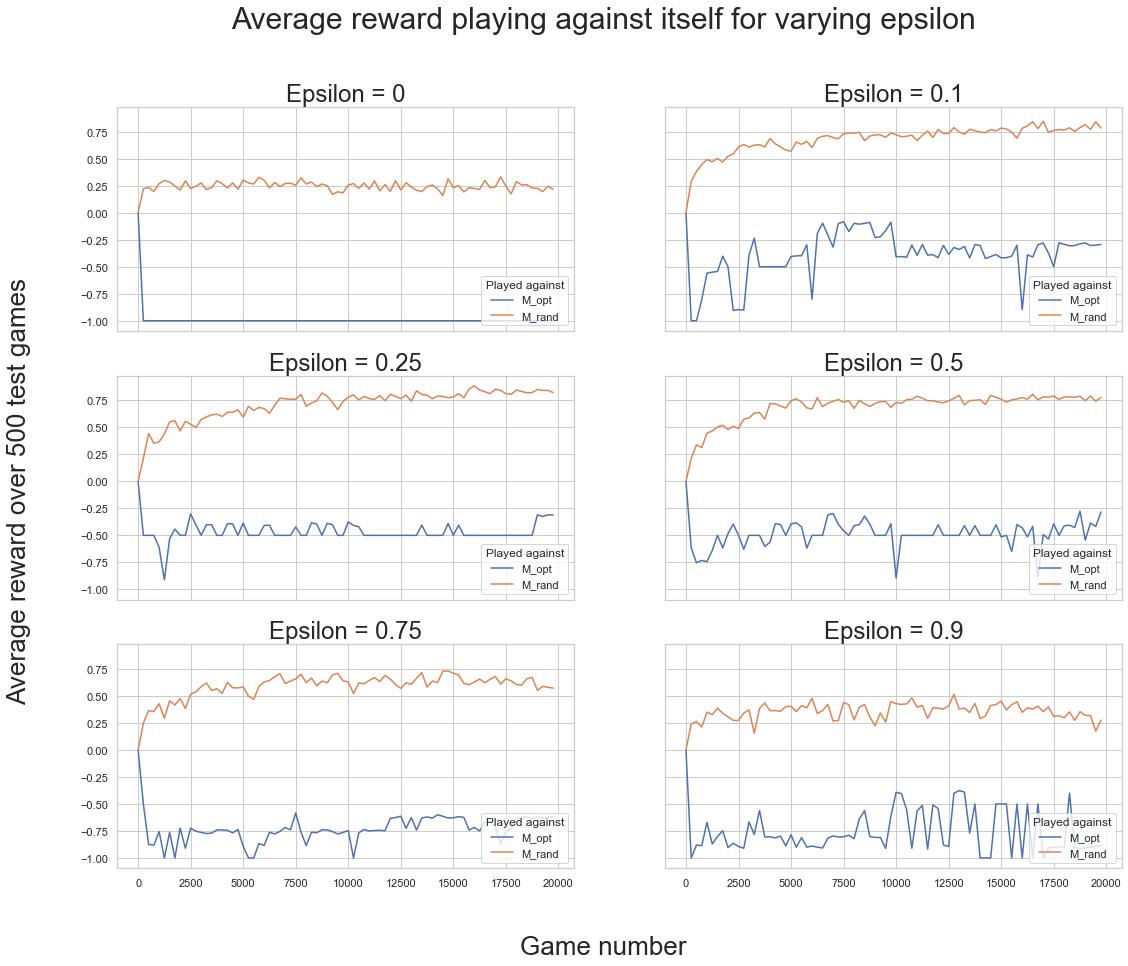

In [215]:
suptitle = 'Average reward playing against itself for varying epsilon'
subtitle = 'Epsilon'
xlabel = 'Game number'
ylabel = 'Average reward over 500 test games'
plot_subplots(3, 2, X, m, e_s, suptitle, xlabel, ylabel,
              labels=['M_opt', 'M_rand'], legend_title='Played against',
              subtitle=subtitle)

#### Question 8

In [ ]:
dec_factors = [1, 5000, 10000, 20000, 30000, 40000]
m_opts, m_rands = [], []

for dec in dec_factors:
    _, m_opt, m_rand, _, Q = train(20000, dec_factor=dec, decrease_epsilon=True, compute_tests=True, itself=True)
    m_opts.append(m_opt)    
    m_rands.append(m_rand)

# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])
    

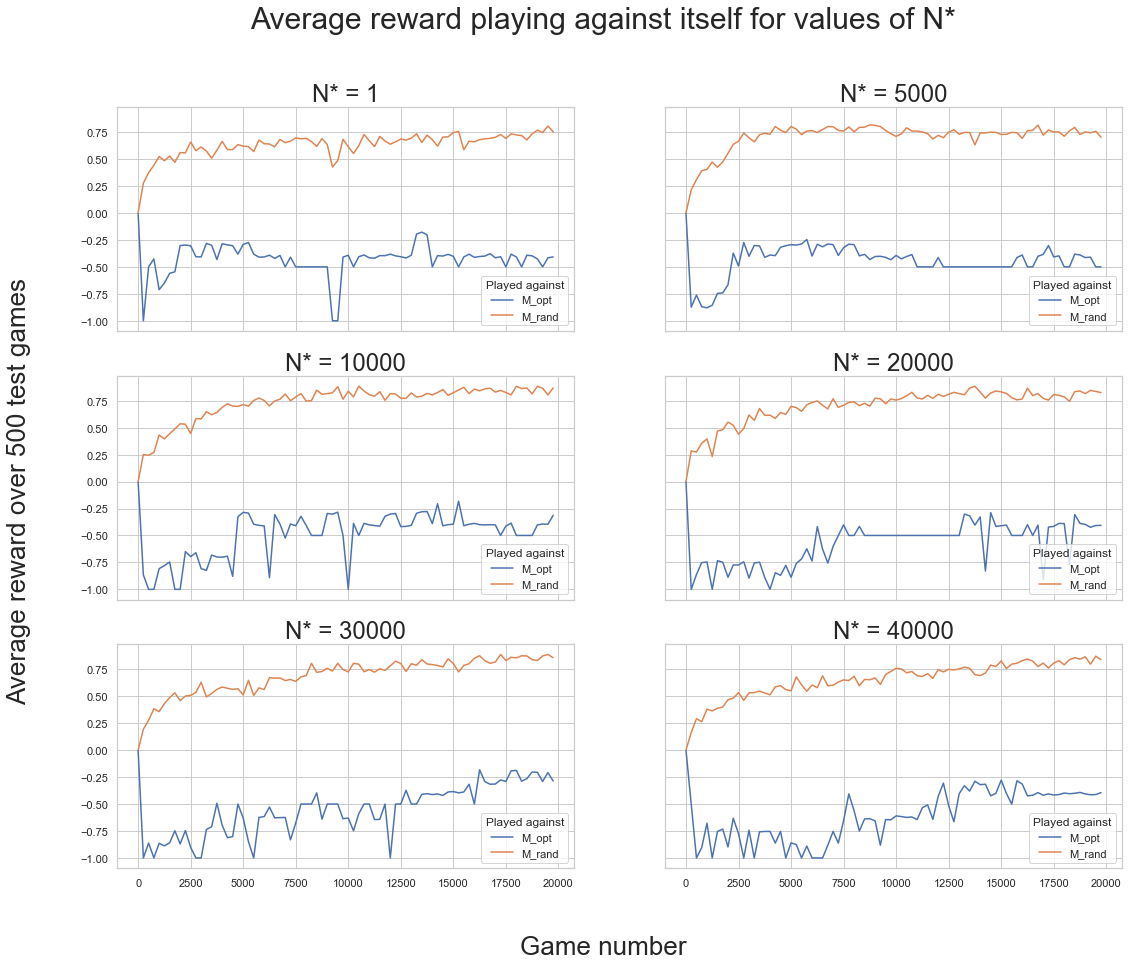

In [231]:
suptitle = 'Average reward playing against itself for values of N*'
subtitle = 'N*'
xlabel = 'Game number'
ylabel = 'Average reward over 500 test games'
plot_subplots(3, 2, X, m, dec_factors, suptitle, xlabel, ylabel,
              labels=['M_opt', 'M_rand'], legend_title='Played against',
              subtitle=subtitle)

#### Question 9

In [190]:
# Training the model that achieved best scores for the training against experts
_, m_opt, m_rand, _, Q = train(20000, dec_factor=30000, decrease_epsilon=True, compute_tests=True, itself=True)

max_m_opts = np.max(np.asarray(m_opt[1:]))
max_m_rands = np.max(np.asarray(m_rand[1:]))

print('The largest values of M_opt and M_rand are:')
print(f'M_opt: {max_m_opts}')
print(f'M_rand: {max_m_rands}')

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
The largest values of M_opt and M_rand are:
M_opt: -0.19
M_rand: 0.906


In [192]:
m_opt = np.asarray(m_opt[1:])
m_rand = np.asarray(m_rand[1:])
max_opt = np.max(np.ravel(m_opt)[1:])
if max_opt==0:
    T_opt = (np.argmax(m_opt>-0.2)+1)*250
else:
    eighty_opt = -(1 - (max_opt+1)*0.8)
    T_opt = (np.argmax(m_opt>eighty_opt)+1)*250

max_rand = np.max(np.ravel(m_rand)[1:])
eighty_rand = max_rand*0.8
T_rand = (np.argmax(m_rand>eighty_rand)+1)*250

print(T_opt, T_rand)

16250 4750


#### Question 10

In [99]:
# Encoding the states we will check out
S1 = TictactoeEnv()
S1.step(0)
S2 = TictactoeEnv()
S2.step(4); S2.step(0); S2.step(6)
S3 = TictactoeEnv()
S3.step(3); S3.step(4); S3.step(5)
S3.step(2); S3.step(6)

actions = [0] + get_legal_moves(S1)
q_values_1 = []
for a in actions:
    q_values_1.append(Q.get(encode(S1,a),0))
q_values_1 = np.asarray(q_values_1)
q_values_1 = q_values_1.reshape((3,3))

q_values_2 = []
for a in actions:
    q_values_2.append(Q.get(encode(S2,a),0))
q_values_2 = np.asarray(q_values_2)
q_values_2 = q_values_2.reshape((3,3))

q_values_3 = []
for a in actions:
    q_values_3.append(Q.get(encode(S3,a),0))
q_values_3 = np.asarray(q_values_3)
q_values_3 = q_values_3.reshape((3,3))

Text(0.5, 48.5, '')

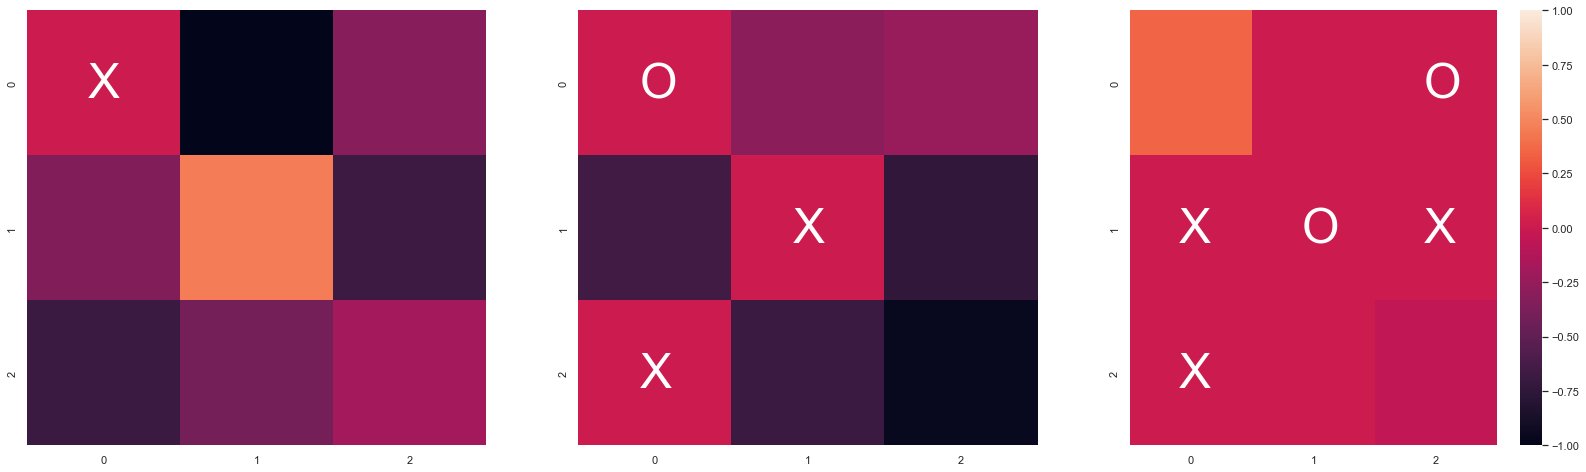

In [100]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(28,8))
g1 = sns.heatmap(q_values_1, cbar=False,ax=ax1, vmin=-1, vmax=1)
ax1.text(0.4, 0.6, 'X', fontsize=48, color='white')
g1.set_ylabel('')
g1.set_xlabel('')
g2 = sns.heatmap(q_values_2, cbar=False,ax=ax2, vmin=-1, vmax=1)
ax2.text(1.4, 1.6, 'X', fontsize=48, color='white')
ax2.text(0.4, 0.6, 'O', fontsize=48, color='white')
ax2.text(0.4, 2.6, 'X', fontsize=48, color='white')
g2.set_ylabel('')
g2.set_xlabel('')
g3 = sns.heatmap(q_values_3, annot=False, annot_kws={'fontsize':'xx-large'}, cbar=True, ax=ax3, vmin=-1, vmax=1)
ax3.text(2.4, 1.6, 'X', fontsize=48, color='white')
ax3.text(0.4, 1.6, 'X', fontsize=48, color='white')
ax3.text(0.4, 2.6, 'X', fontsize=48, color='white')
ax3.text(1.4, 1.6, 'O', fontsize=48, color='white')
ax3.text(2.4, 0.6, 'O', fontsize=48, color='white')
g3.set_ylabel('')
g3.set_xlabel('')


## Deep Q-Learning

In [1]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")

#### Helpers

In [ ]:
# Constants
BATCH_SIZE = 64 # Take batches of 64
TARGET_UPDATE = 500 # Update every 500 game

def grid2tensor(grid, player = 'X'):
    """ Helper for converting numpy grid to tensor grid
        Args:
            grid: ndarray[Int]. Grid representation of current state.
            player: Char. Player to compute the tensor grid for. 
        Returns: 
            torch.tensor[Int]. Tensor representation of grid
    """
    # Returning None if Grid is None
    if grid is None:
        return None

    result_p = np.zeros((3, 3))
    result_o = np.zeros((3, 3))
    # Convert player to integer
    player_value = 1 if player == 'X' else -1
    # Retrieve indices of both players positions
    player_mask = np.where(grid == player_value)
    opposition_mask = np.where(grid == - player_value)
    # Insert values into final result
    result_p[player_mask] = 1
    result_o[opposition_mask] = 1
    result = np.array([result_p, result_o])
    # Reshape to shape expected by neural network and convert to tensor
    return torch.from_numpy(result).type(torch.float32)[None]

In [152]:
# Model class
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        # Define hidden layers and add Batch Normalization as we're using ReLu
        self.l1 = nn.Linear(in_features=3*3*2, out_features=128)
        #self.bn1 = nn.BatchNorm2d(128)
        self.l2 = nn.Linear(in_features=128, out_features=128)
        #self.bn2 = nn.BatchNorm2d(128)
        self.l3 = nn.Linear(in_features=128, out_features=9)

    def forward(self, x):
        x = x.view(x.shape[0], 3*3*2)
        x = x.to(device)
        x = F.relu((self.l1(x.float())))
        x = F.relu((self.l2(x)))
        x = self.l3(x)
        return x

    # method to take an action given a state
    def act(self, state):
        with torch.no_grad():
            return self.forward(state).max(1)[1].view(1, 1)


# Framework for Replay Memory that stores transitions in games
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory(object):
    """Copied verbatim from the PyTorch DQN tutorial.
    During training, observations from the replay memory are
    sampled for policy learning.
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:

# The following function: optimize_model is a direct copy from the Pytorch DQN tutorial.
# Information can be found here: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html. 
# We also use inspiration from this guide: https://mahowald.github.io/pytorch-dqn/ in our implmentation of the DQN

def optimize_model(policy_net, target_net, memory, optimizer, batch_size):
    if len(memory) < batch_size:
        return # Do nothing

    # Get batch-array of transitions, and convert to Transition of batch-arrays
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Mask of non-final states
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device
    )

    # Non-final states
    if batch_size > 1:
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # Unpack batch
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Action taken from policy for each state
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute values for next state based on target_net, zero if final
    next_state_values = torch.zeros(batch_size, device=device)
    if batch_size > 1:
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()


    # Expected Q--values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber loss (delta defaults to 1)
    criterion = nn.HuberLoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))


    # Optimize
    optimizer.zero_grad()
    loss.backward()
    for i, param in enumerate(policy_net.parameters()):
        if param.grad is not None:
            param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss.detach()


# function is from: https://mahowald.github.io/pytorch-dqn/
def select_model_action(
    device: torch.device, model: DQN, state: torch.tensor, eps: float, S: TictactoeEnv
):
    """Selects an action for the model: either using the policy, or
    by choosing a random valid action (as controlled by `eps`)
    
    Arguments:
        device {torch.device} -- Device
        model {Policy} -- Policy module
        state {torch.tensor} -- Current board state, as a torch tensor
        eps {float} -- Probability of choosing a random state.
    
    Returns:
        Tuple[torch.tensor, bool] -- The action, and a bool indicating whether
                                     the action is random or not.
    """

    sample = random.random()
    if sample >= eps:
        return model.act(state)
    else:
        # per the announcement "A CLARIFICATION FOR THE MINI-PROJECTS"
        # we sample the action uniformly in legal actions for the exploratory actions
        return (
            torch.tensor(
                [[random.choice(get_legal_moves(S))]],
                device=device,
                dtype=torch.long,
            ))

In [ ]:
# We test on policy net, as using the target net would be the same as 
# using the policy net from X iterations backwards
def test_deep(policy_net, rand, e=0):
    ''' Function for computing M_opt and M_rand \n
        Params:
            policy_net: DQN. Learned Q function. 
            rand: Boolean. True if calculating M_rand and False if calculating M_opt.
            e: Float. Exploration level, should be zero for testing. 
        Returns: 
            Float. (num_wins - num_losses) / num_games
    '''
    rewards = []
    S = TictactoeEnv()
    for i in range(500): # Fixed number of test games
        np.random.seed(i) # Different seed for each iteration
        # int(False) = 0 => optimal player, else random player
        p = OptimalPlayer(int(rand), 'O') if i % 2 == 0 else OptimalPlayer(int(rand), 'X')
        while not S.end:
            if S.current_player != p.player:
                A = select_model_action(device, policy_net, grid2tensor(S.grid), e, S)
                A = A.item()
                if not S.check_valid(A):
                    rewards.append(-1)
                    S.reset()
                    break
            else:
                A = p.act(S.grid)

            _, end, _ = S.step(A)
            if end:
                # 1 if policy wins, -1 if policy loses, else 0
                R = - S.reward(player=p.player)
                rewards.append(R)
                S.reset()
                break

    return sum(rewards)  / len(rewards)


def train_deep(N, optimizer, policy_net, target_net, e=0.1, e_opt = 0.5,
            decrease_epsilon=False, dec_factor = 1, memory=ReplayMemory(10000), 
            compute_tests=False, compute_every=250, against_itself=False, batch_size=BATCH_SIZE
            ):
    """ Function for training a deep Q-learning network \n
    Args:
        N: Int. Number of games.
        optimizer: torch.optim.Optimizer. Optimizer to be used.
        policy_net: DQN. Policy network.
        target_net: DQN. Target network.
        e: Float. Epsilon value in [0, 1].
        e_opt: Float. Epsilon value for OptimalPlayer in [0, 1]
        decrease_epsilon: Boolean. True if epsilon should be decreased each game.
        dec_factor: Int. Decreasing factor for epsilon.
        memory: ReplayMemory. Memory to sample from when optimizing model.
        compute_tests: Boolean. True if M_opt and M_rand should be computed.
        compute_every: Int. Number of games before compute training and test average.
        against_itself: Boolean. True if the algorithm should learn by playing itself.
        batch_size: Int. Size of batch to sample from memory. 
    Returns: 
        Tuple[List[Float]]. Training rewards, losses, M_opt and M_rand,
        averaged over buckets of size compute_every 
    """
    # initializing variables to keep track of rewards etc.
    rewards = []
    losses = []

    curr_rew = []
    curr_loss = []

    m_opts, m_rands = [], []


    Q = {}
    #playing N times
    for i in range(N):
        # creating game
        S = TictactoeEnv()
        state = grid2tensor(S.grid)
        opt = OptimalPlayer(e_opt, 'O') if i % 2 == 0 else OptimalPlayer(e_opt, 'X')

        if decrease_epsilon:
            e = max(E_MIN, E_MAX*(1 - i / dec_factor))
        
        if compute_tests and i % compute_every == 0:
            m_opt, m_rand = test_deep(policy_net, False), test_deep(policy_net, True)
            m_opts.append(m_opt)
            m_rands.append(m_rand)
        
        # if optimal player is first, let him do his first action before the loop
        # this ensure every round in the loop is: player act, optimal act, states and rewards pushed to memory
        if S.current_player == opt.player and not against_itself:
            action_opt = opt.act(S.grid)
            state, _, _ = S.step(action_opt)
            state = grid2tensor(state)

        # playing until game ends
        while not S.end:

            # runs if the agent learns by playing against itself
            if against_itself:
                reward = play_against_itself(S, e, policy_net, memory)
                S.reset()
                break
            
            # making an action
            if S.current_player != opt.player:
                A = select_model_action(device, policy_net, grid2tensor(S.grid), e, S)
                valid = S.check_valid(int(A))
                if not valid:
                    end = True
                else:
                    next_state, end, _ = S.step(A.item())

                # optimal player makes his action
                if not S.end and not end:
                    action_opt = opt.act(S.grid)
                    next_state, _, _ = S.step(action_opt)
            else:
                action_opt = opt.act(S.grid)
                next_state, _, _ = S.step(action_opt)

            # calculating rewards if the game is over
            if S.end or end:
                next_state=None 
                if S.end:
                    reward = -S.reward(player=opt.player)
                else:
                    reward= -1
            else:
                reward = 0
            
            # pushing state, action, reward to memory
            # print(next_state)
            next_state = grid2tensor(next_state)
            if type(A) is tuple:
                A = A[1]+A[0]*(3)
                A = torch.tensor([[A]], device=device)
            memory.push((state), A, (next_state), torch.tensor([reward], device=device))
            state = next_state

            # new game if the current game is finished
            if end==True:
                break
        
        # optimizing the model
        loss = optimize_model(policy_net, target_net, memory, optimizer, batch_size=batch_size)
        
        curr_rew.append(reward)
        curr_loss.append(loss)
        
        if i % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if (i%250==0) and i!=0:
            mean_rew = np.asarray([element for element in curr_rew if element!=None]).mean()
            mean_loss = np.nanmean(np.asarray([element for element in curr_loss if element!=None]))
            curr_rew = []
            curr_loss = []
            rewards.append(mean_rew)
            losses.append(mean_loss)
        if i%5000 == 0:
            print(i)
    return rewards, losses, m_opts, m_rands

def play_against_itself(S, e, policy_net, memory):
    """ Function for model to play one game of tic tac toe against itself \n
        Args:
            S: TictactoeEnv. State of game.
            e: Float. Epsilon value in [0, 1].
            policy_net: DQN. Policy network.
            memory: ReplayMemory. Memory to sample from when optimizing model. 
        Returns: 
            List[Float]. Training rewards.
    """
    
    # Init state
    end = False
    flip = True    
    prev_state = grid2tensor(S.grid)
    A = select_model_action(device, policy_net, prev_state, e, S)
    state, *_ = S.step(A.item())
    state = grid2tensor(state)
    prev_A = A
    A = select_model_action(device, policy_net, state, e, S)
    
    # Skriver tankene her
    while True:

        if S.check_valid(int(A)):
            next_state, end, winner = S.step(A.item())
            next_state = grid2tensor(next_state)
            if end:
                # If flip is true, we play from "the other side of the table"
                reward = S.reward('O' if flip else 'X')
                # Check format
                if type(A) is tuple:
                    A = A[1]+A[0]*(3)
                    A = torch.tensor([[A]], device=device)
                if type(prev_A) is tuple:
                    prev_A = prev_A[1]+prev_A[0]*(3)
                    prev_A = torch.tensor([[prev_A]], device=device)
                # Push to memory
                push_to_memory(memory, prev_state, prev_A, None, -reward, not flip)
                push_to_memory(memory, state, A, None, reward, flip)
                break
        else:
            reward = 0
            if type(A) is tuple:
                    A = A[1]+A[0]*(3)
                    A = torch.tensor([[A]], device=device)
            if type(prev_A) is tuple:
                prev_A = prev_A[1]+prev_A[0]*(3)
                prev_A = torch.tensor([[prev_A]], device=device)
            push_to_memory(memory, prev_state, prev_A, None, 0, not flip)
            push_to_memory(memory, state, A, None, -1, flip)
            break # Only get here if one player makes illegal move

        if type(prev_A) is tuple:
                prev_A = prev_A[1]+prev_A[0]*(3)
                prev_A = torch.tensor([[prev_A]], device=device)

        # Push last round to memory and increment state
        push_to_memory(memory, prev_state, prev_A, next_state, 0, not flip)
        flip = not flip # Switch player
        prev_A = A
        A = select_model_action(device, policy_net, next_state, e, S)
        prev_state = state
        state = next_state
        
    return reward

def push_to_memory(memory, state, A, next_state, reward, flip):
    """ Helper for pushing to memory "from both sides of the table" \n
        Args:
            memory: ReplayMemory. Memory to push to.
            state: torch.tensor[Int]. State before taking action.
            A: torch.tensor[Int]. Action that was taken. 
            next_state: torch.tensor[Int]. Next state resulting from action A, or None if end of game
            reward: Int. Reward for taking action A.
            flip: Boolean. True if we flip the perspective of the player. 
    """
    if flip:
        next = None if next_state is None else torch.flip(next_state, (1, )) 
        memory.push(torch.flip(state, (1, )), A, next, 
                    torch.tensor([reward], device=device))
    else:
        memory.push(state, A, next_state, torch.tensor([reward], device=device))

In [ ]:
memory = ReplayMemory(10000)

# Creating policy and target networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Use Adam optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

rewards, losses, *_ = train_deep(20000, optimizer, policy_net, target_net)

#### Question 11

Text(0, 0.5, 'Average loss')

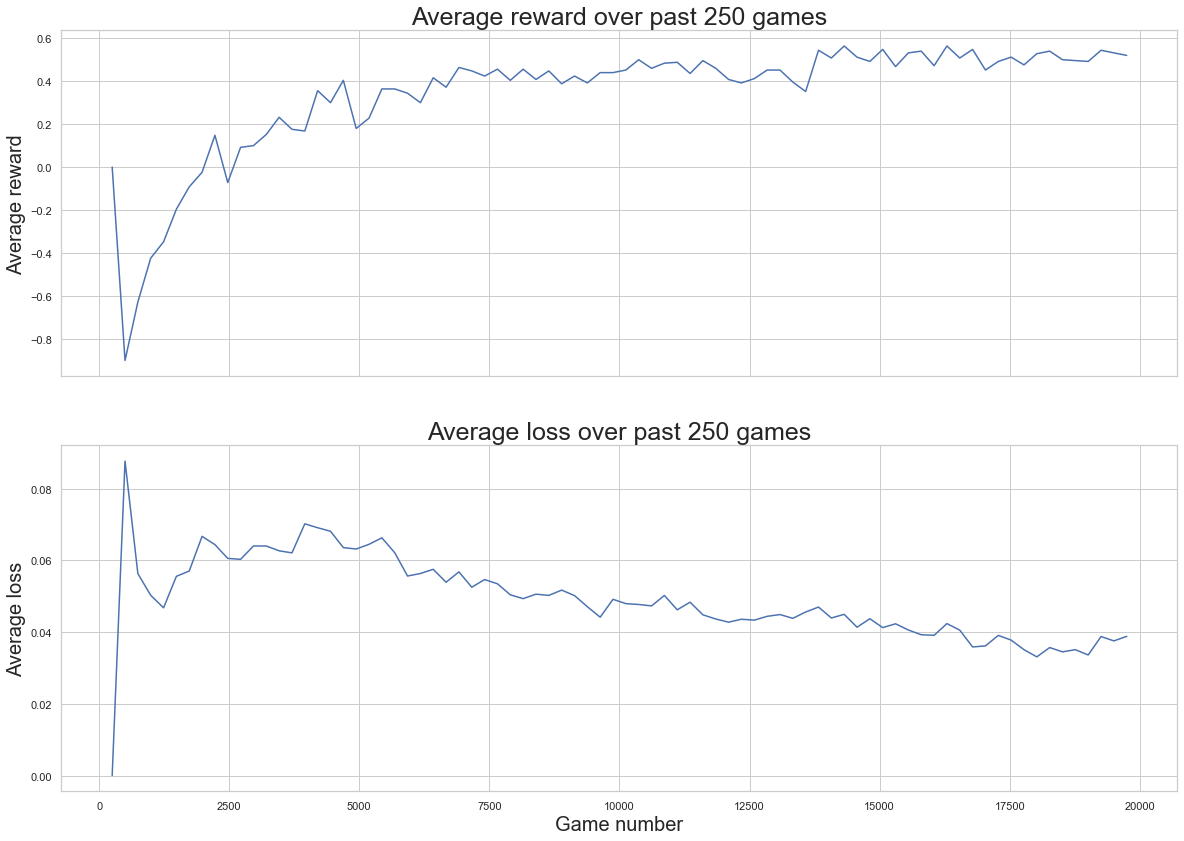

In [117]:
sns.set_theme(style='whitegrid')
fig, axs = plt.subplots(2, 1, figsize=(20, 14), sharex=True)
X = np.linspace(250, 19750, 20000 // 250)
plt.xlabel('Game number', fontsize=20)
plt.ylabel('Avg. reward for past 250 games', fontsize=18)

sns.lineplot(x=X, y=[0]+rewards, ax=axs[0])
sns.lineplot(x=X, y=[0]+losses, ax=axs[1])

axs[0].set_title('Average reward over past 250 games', fontsize=25)
axs[1].set_title('Average loss over past 250 games', fontsize=25)

axs[0].set_ylabel('Average reward', fontsize=20)
axs[1].set_ylabel('Average loss', fontsize=20)

The loss decreases and the agent learns to play Tic Tac Toe

#### Question 12 

0
5000
10000
15000


Text(0, 0.5, 'Average loss')

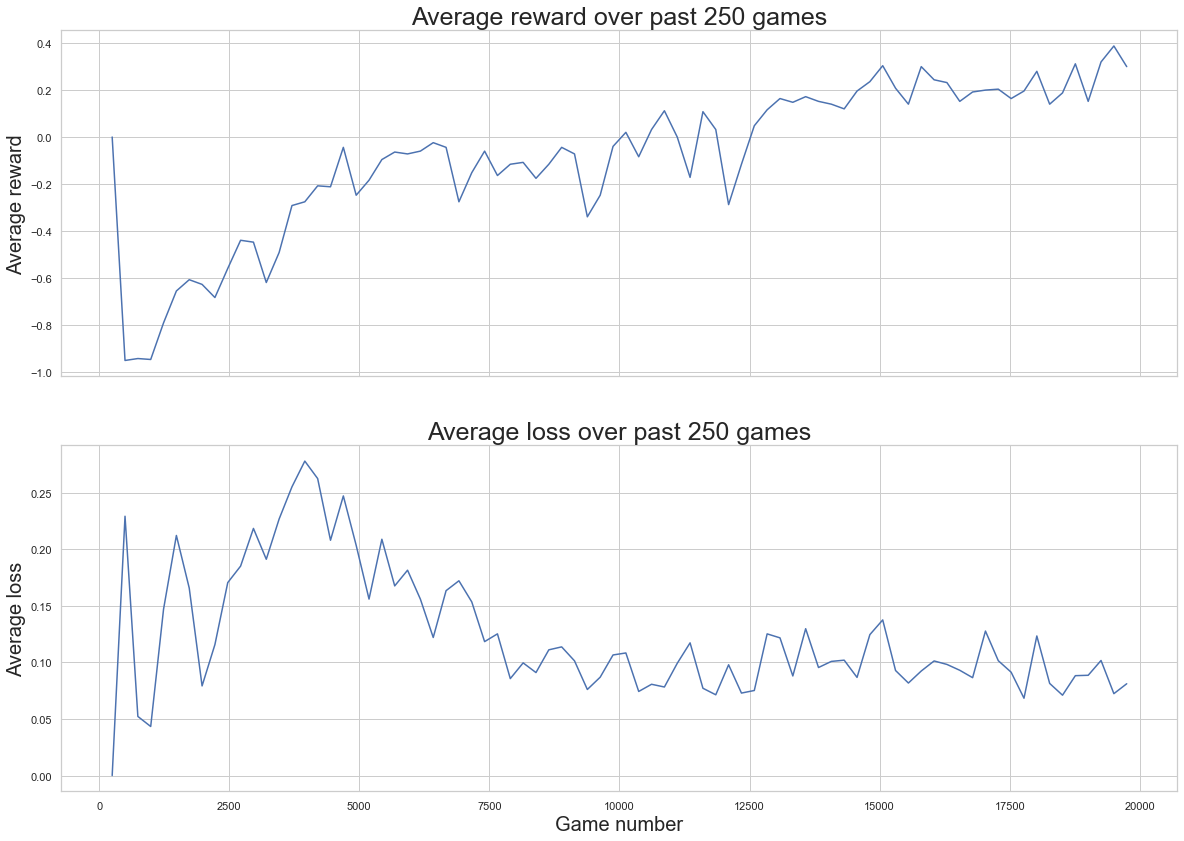

In [118]:
memory = ReplayMemory(1)

# Creating policy and target networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Use Adam optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

rewards, losses, *_ = train_deep(20000, optimizer, policy_net, target_net, memory = memory, batch_size=1)

fig, axs = plt.subplots(2, 1, figsize=(20, 14), sharex=True)
sns.set_theme(style='whitegrid')
X = np.linspace(250, 19750, 20000 // 250)
plt.xlabel('Game number', fontsize=20)
plt.ylabel('Avg. reward for past 250 games', fontsize=18)

sns.lineplot(x=X, y=[0]+rewards, ax=axs[0])
sns.lineplot(x=X, y=[0]+losses, ax=axs[1])

axs[0].set_title('Average reward over past 250 games', fontsize=25)
axs[1].set_title('Average loss over past 250 games', fontsize=25)

axs[0].set_ylabel('Average reward', fontsize=20)
axs[1].set_ylabel('Average loss', fontsize=20)


#### Question 13

In [ ]:
dec_factors = [1, 5000, 10000, 20000, 30000, 40000]

m_opts = []
m_rands = []

for dec in dec_factors:
    memory = ReplayMemory(10000)
    # Creating policy and target networks
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # Use Adam optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

    _, _, dec_m_opts, dec_m_rands = train_deep(
        20000, optimizer, policy_net, target_net, 
        decrease_epsilon=True, dec_factor = dec, memory = memory,
        compute_tests=True
    )
    m_opts.append(dec_m_opts)
    m_rands.append(dec_m_rands)


# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])

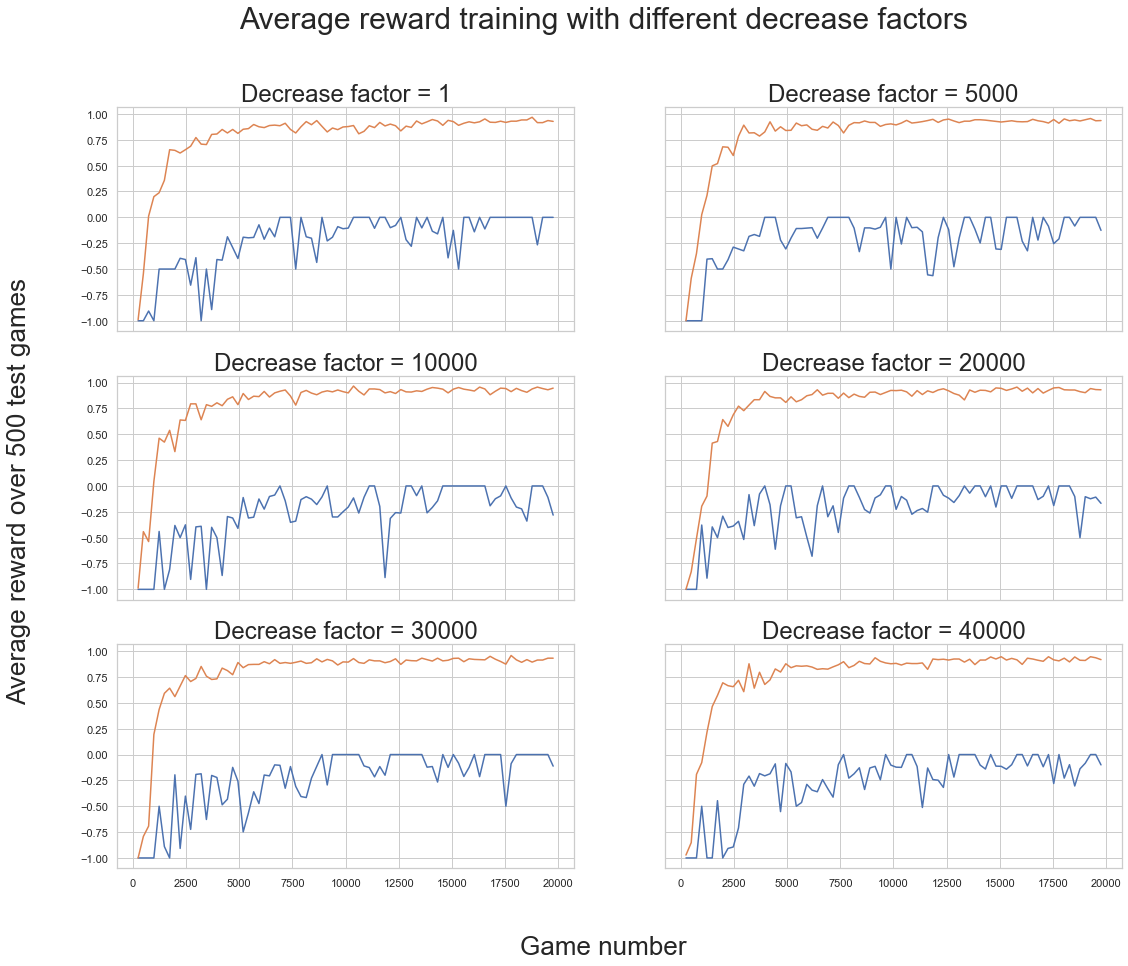

In [120]:
suptitle = 'Average reward training with different decrease factors'
subtitle = 'Decrease factor'
xlabel = 'Game number'
ylabel = 'Average reward over 500 test games'
#rewards = np.expand_dims(rewards, 1)
plot_subplots(3, 2, X, m, dec_factors, suptitle, 
              xlabel, ylabel, subtitle=subtitle)

#### Question 14

In [ ]:
e_opts = [0, 0.1, 0.25, 0.5, 0.75, 0.9]

m_opts = []
m_rands = []

for e_opt in e_opts:
    # Creating policy and target networks
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # Use Adam optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

    _, _, dec_m_opts, dec_m_rands = train_deep(
        20000, optimizer, policy_net, target_net,0.1, e_opt, dec_factor = 1,
        decrease_epsilon=True, compute_tests=True
    )

    m_opts.append(dec_m_opts)
    m_rands.append(dec_m_rands)


# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])    

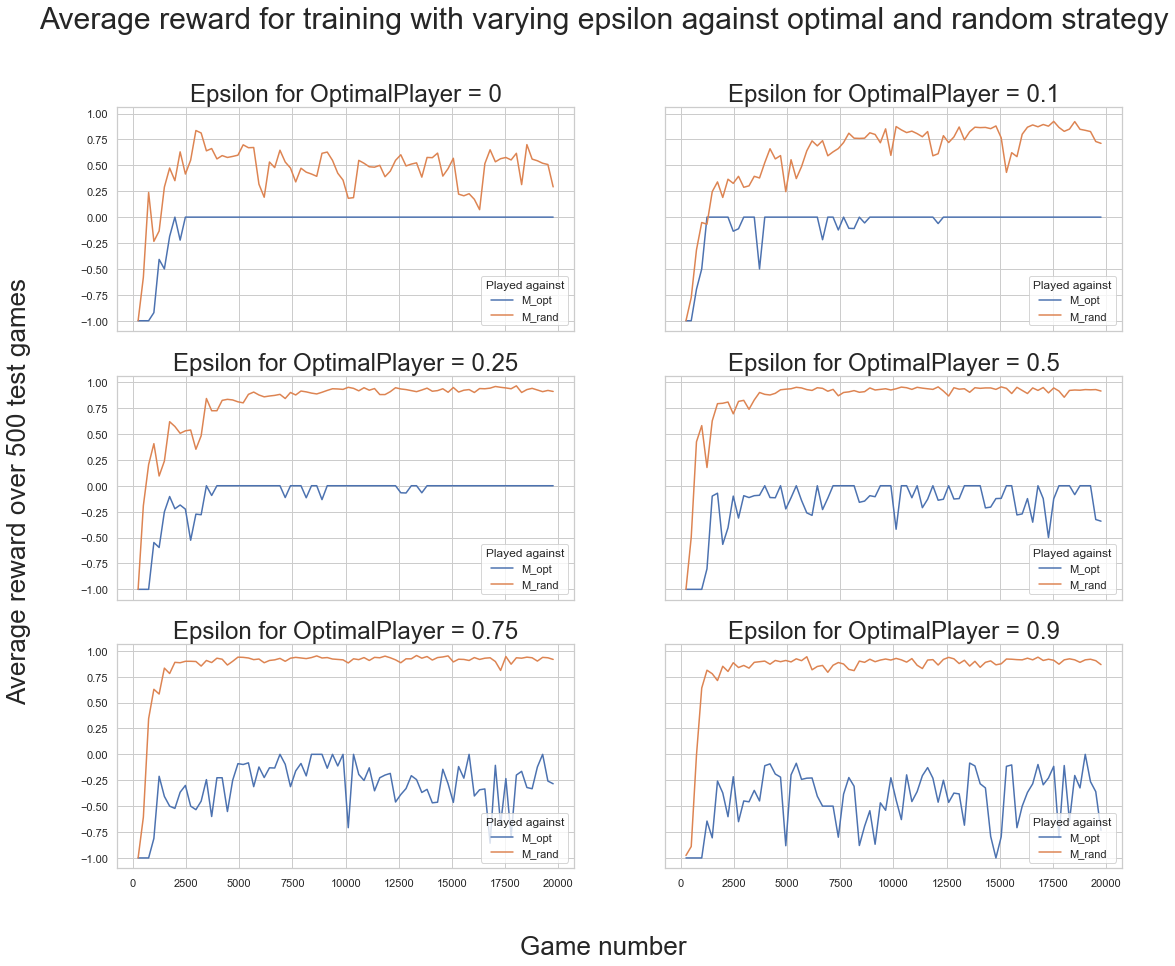

In [134]:
suptitle = 'Average reward for training with varying epsilon against optimal and random strategy'
subtitle = 'Epsilon for OptimalPlayer'
xlabel = 'Game number'
ylabel = 'Average reward over 500 test games'
plot_subplots(3, 2, X, m, e_opts, suptitle, 
              xlabel, ylabel, labels=['M_opt', 'M_rand'], 
              subtitle=subtitle, legend_title='Played against')

#### Question 15

In [136]:
# Creating policy and target networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

#Use Adam optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

_, _, m_opts, m_rands = train_deep(
20000, optimizer, policy_net, target_net, 0.1, 0.25, dec_factor = 1,
decrease_epsilon=True, compute_tests=True
)

print(f'After playing 20,000 games, the highest value of M_opt was {np.max(np.ravel(m_opts)[1:])},\
        and the highest value of M_rand was {np.max(np.ravel(m_rands)[1:])}')

0
5000
10000
15000
After playing 20,000 games, the highest value of M_opt was 0.0,        and the highest value of M_rand was 0.962


In [137]:
m_opt = m_opts
m_rand = m_rands

m_opt = np.asarray(m_opt[1:])
m_rand = np.asarray(m_rand[1:])
max_opt = np.max(np.ravel(m_opts)[1:])
if max_opt==0:
    T_opt = (np.argmax(m_opt>-0.2)+1)*250
else:
    eighty_opt = -(1 - (max_opt+1)*0.8)
    T_opt = (np.argmax(m_opt>eighty_opt)+1)*250

max_rand = np.max(np.ravel(m_rands)[1:])
eighty_rand = max_rand*0.8
T_rand = (np.argmax(m_rand>eighty_rand)+1)*250

print(T_opt, T_rand)

2750 2750


### 3.3 Learning by self-practice

#### Question 16

In [146]:
epsilons = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9]
m_opts = []
m_rands = []

for e in epsilons:
    memory = ReplayMemory(10000)
    # Creating policy and target networks
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # Use Adam optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

    _, _, dec_m_opts, dec_m_rands = train_deep(
        20000, optimizer, policy_net, target_net, e=e,
        memory = memory, compute_tests=True, against_itself=True
    )
    m_opts.append(dec_m_opts)
    m_rands.append(dec_m_rands)


# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])    

0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000


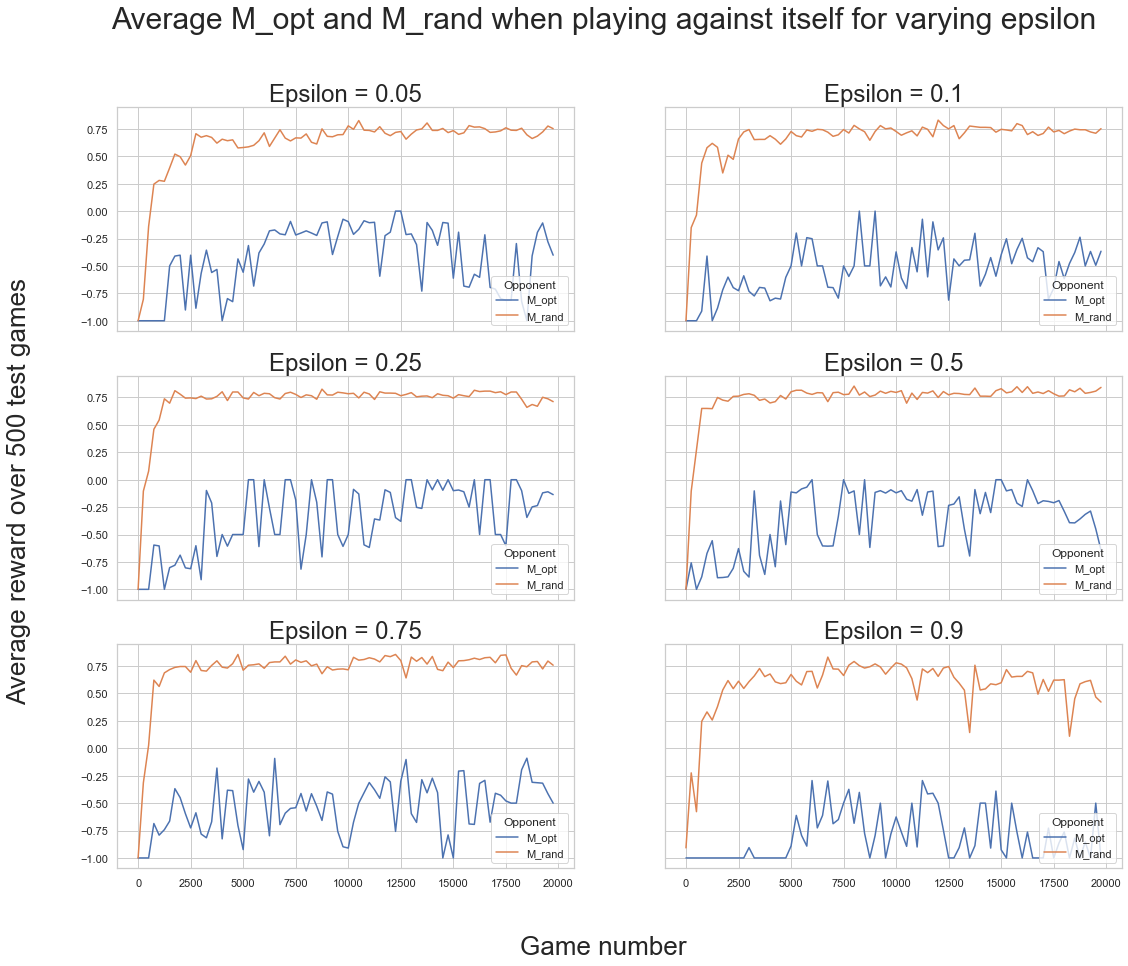

In [147]:
suptitle = 'Average M_opt and M_rand when playing against itself for varying epsilon'
subtitle = 'Epsilon'
xlabel = 'Game number'
ylabel = 'Average reward over 500 test games'
labels = ['M_opt', 'M_rand']
X = np.linspace(0, 19750, 20000 // 250)
plot_subplots(3, 2, X, m, epsilons, suptitle, 
              xlabel, ylabel, subtitle=subtitle,
              labels=labels, legend_title='Opponent')

#### Question 17

In [148]:
dec_factors = [1, 5000, 10000, 20000, 30000, 40000]

m_opts = []
m_rands = []

for dec_factor in dec_factors:
    # Creating policy and target networks
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # Use Adam optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

    _, _, dec_m_opts, dec_m_rands = train_deep(
        20000, optimizer, policy_net, target_net,
        decrease_epsilon=True, dec_factor=dec_factor, compute_tests=True, against_itself=True
    )
    m_opts.append(dec_m_opts)
    m_rands.append(dec_m_rands)


# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])    

0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000


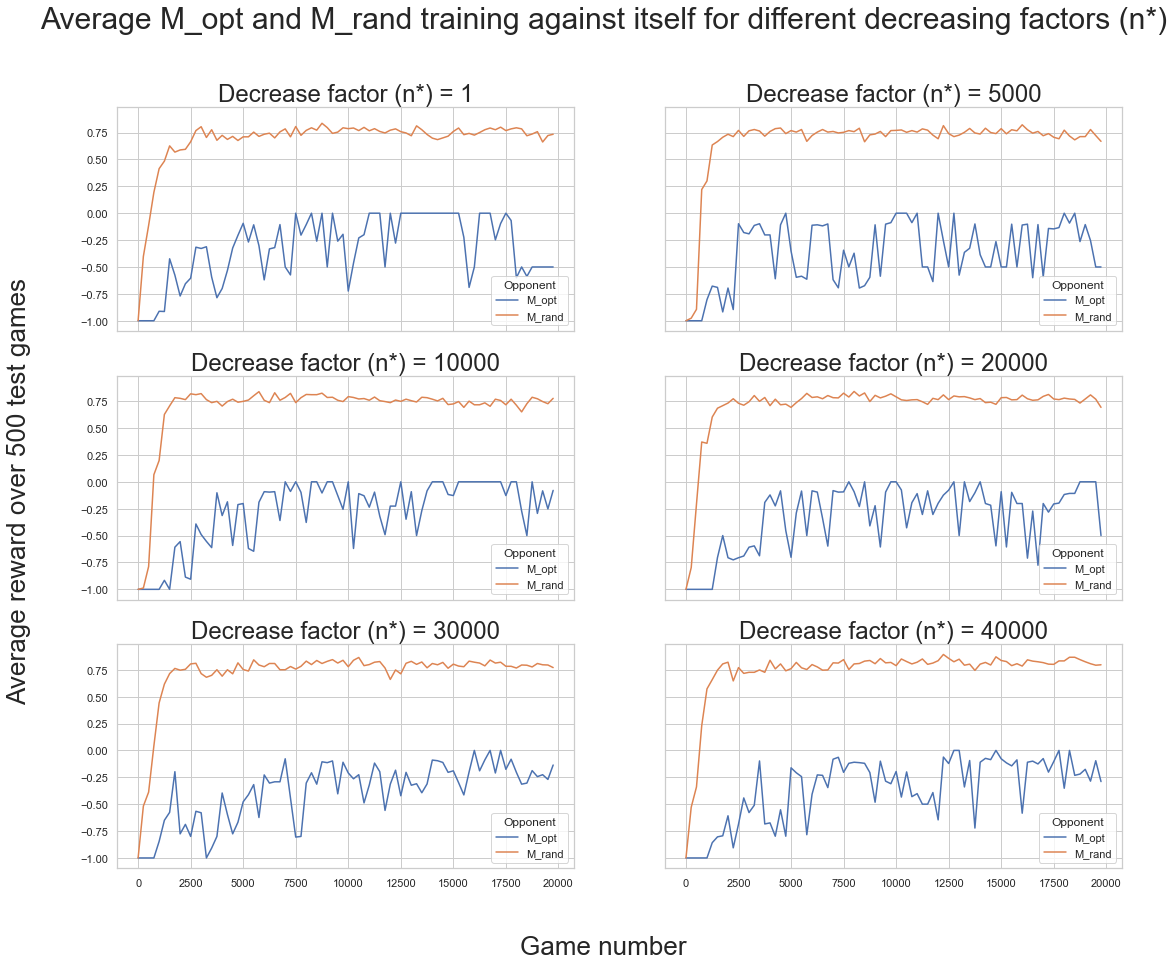

In [149]:
suptitle = 'Average M_opt and M_rand training against itself for different decreasing factors (n*)'
subtitle = 'Decrease factor (n*)'
xlabel = 'Game number'
ylabel = 'Average reward over 500 test games'
labels = ['M_opt', 'M_rand']
plot_subplots(3, 2, X, m, dec_factors, suptitle, 
              xlabel, ylabel, subtitle=subtitle,
              labels=labels, legend_title='Opponent')

#### Question 18

In [150]:
# Creating policy and target networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Use Adam optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

_, _, dec_m_opts, dec_m_rands = train_deep(
20000, optimizer, policy_net, target_net,
decrease_epsilon=True, dec_factor=10000, compute_tests=True, against_itself=True
)

print(f'After playing 20,000 games, the highest value of M_opt was {np.max(np.ravel(dec_m_opts)[1:])},\
        and the highest value of M_rand was {np.max(np.ravel(dec_m_rands)[1:])}')

0
5000
10000
15000
After playing 20,000 games, the highest value of M_opt was 0.0,        and the highest value of M_rand was 0.844


In [153]:
m_opt = dec_m_opts
m_rand = dec_m_rands

m_opt = np.asarray(m_opt[1:])
m_rand = np.asarray(m_rand[1:])
max_opt = np.max(np.ravel(m_opts)[1:])
if max_opt==0:
    T_opt = (np.argmax(m_opt>-0.2)+1)*250
else:
    eighty_opt = -(1 - (max_opt+1)*0.8)
    T_opt = (np.argmax(m_opt>eighty_opt)+1)*250

max_rand = np.max(np.ravel(m_rands)[1:])
eighty_rand = max_rand*0.8
T_rand = (np.argmax(m_rand>eighty_rand)+1)*250

print(T_opt, T_rand)

3500 1500


#### Question 19

Text(0.5, 48.5, '')

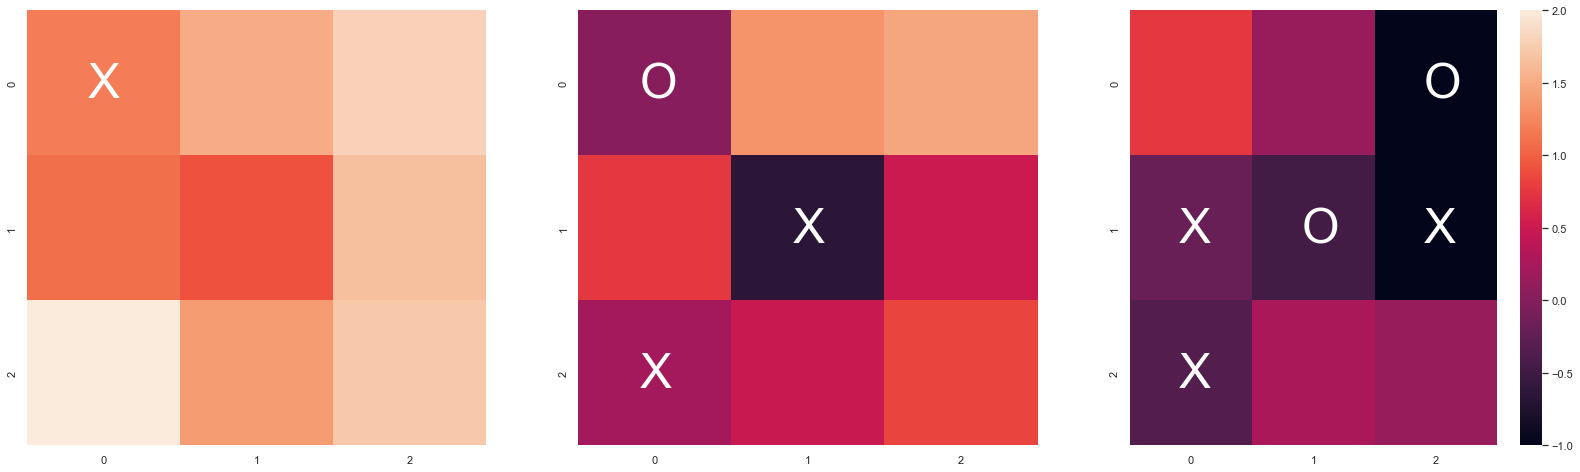

In [167]:
# Encoding the states we will check out (same as in Q10)
S1 = TictactoeEnv()
S1.step(0)#; S1.step(4)
S2 = TictactoeEnv()
S2.step(4); S2.step(0); S2.step(6)
S3 = TictactoeEnv()
S3.step(3); S3.step(4); S3.step(5)
S3.step(2); S3.step(6)

board1 = grid2tensor(S1.grid)
board2 = grid2tensor(S2.grid)
board3 = grid2tensor(S3.grid)

Q1 = policy_net(board1).detach().numpy().reshape((3, 3))
Q2 = policy_net(board2).detach().numpy().reshape((3, 3))
Q3 = policy_net(board3).detach().numpy().reshape((3, 3))

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(28,8))
g1 = sns.heatmap(Q1, cbar=False, ax=ax1, vmin=-1, vmax=2)
ax1.text(0.4, 0.6, 'X', fontsize=48, color='white')
g1.set_ylabel(''); g1.set_xlabel('')
g2 = sns.heatmap(Q2, cbar=False,ax=ax2, vmin=-1, vmax=2)
ax2.text(1.4, 1.6, 'X', fontsize=48, color='white')
ax2.text(0.4, 0.6, 'O', fontsize=48, color='white')
ax2.text(0.4, 2.6, 'X', fontsize=48, color='white')
g2.set_ylabel(''); g2.set_xlabel('')
g3 = sns.heatmap(Q3, annot=False, annot_kws={'fontsize':'xx-large'}, cbar=True, ax=ax3, vmin=-1, vmax=2)
ax3.text(2.4, 1.6, 'X', fontsize=48, color='white')
ax3.text(0.4, 1.6, 'X', fontsize=48, color='white')
ax3.text(0.4, 2.6, 'X', fontsize=48, color='white')
ax3.text(1.4, 1.6, 'O', fontsize=48, color='white')
ax3.text(2.4, 0.6, 'O', fontsize=48, color='white')
g3.set_ylabel(''); g3.set_xlabel('')

## 4 Comparing *Q*-learning witg Deep *Q*-learning

#### Question 20

See table in report

#### Question 20


See report